# データ作成

In [1]:
import numpy as np
import pandas as pd
import py4macro

データファイルの作成のためには，以下で説明するGDPと失業率のファイルをこのJupyter Notebookと同じフォルダーに置くことを前提とする。

## GDP

* 1980Q1-1993Q4: 実額・四半期・実質季節調整系列（CSV形式：34KB）
* 平成27年(2015年)基準支出側GDP系列簡易遡及
* ファイル名：gaku-jk_2780.csv
* [リンク](https://www.esri.cao.go.jp/jp/sna/data/data_list/h27_retroactive/27kani_top.html)

In [2]:
df1980_1993 = pd.read_csv('gaku-jk_2780.csv', encoding='cp932').iloc[6:-8,:2]
df1980_1993.head()
df1980_1993.tail()

,実質季節調整系列,Unnamed: 1
57,10-12.,"442,920.2"
58,1993/ 1- 3.,"445,162.3"
59,4- 6.,"441,409.6"
60,7- 9.,"439,390.1"
61,10-12.,"441,089.0"


* 1994Q1-2021Q4: 実額・四半期・実質季節調整系列（CSV形式：34KB）
* 平成27年(2015年)基準支出側GDP系列
* ファイル名：gaku-jk2142.csv
* [リンク](https://www.esri.cao.go.jp/jp/sna/data/data_list/sokuhou/files/2021/qe214_2/gdemenuja.html)

In [3]:
df1994_2021 = pd.read_csv('gaku-jk2142.csv', encoding='cp932').iloc[6:-3,:2]
df1994_2021.head()
# df1994_2021.tail()

,実質季節調整系列,Unnamed: 1
6,1994/ 1- 3.,"446,307.3"
7,4- 6.,"443,743.5"
8,7- 9.,"448,944.9"
9,10-12.,"447,168.4"
10,1995/ 1- 3.,"452,112.9"


データの結合

In [4]:
df_gdp = pd.concat([df1980_1993,df1994_2021],axis=0)
df_gdp.head()
df_gdp.tail()

,実質季節調整系列,Unnamed: 1
113,10-12.,"537,791.8"
114,2021/ 1- 3.,"534,867.8"
115,4- 6.,"537,992.3"
116,7- 9.,"534,176.4"
117,10-12.,"540,210.6"


列名変更

In [5]:
df_gdp.columns = ['year','gdp']
df_gdp.head(2)

,year,gdp
6,1980/ 1- 3.,"269,747.5"
7,4- 6.,"268,521.8"


* インデックの変更
* 列`year`を削除

In [6]:
start = str(1980)

idx = pd.Series(pd.date_range(start, freq='Q', periods=len(df_gdp)))
df_gdp = df_gdp.set_index(idx).drop('year',axis=1)
df_gdp.columns

Index(['gdp'], dtype='object')

* 数字の`,`を削除
* `float`に変換

In [7]:
df_gdp['gdp'] = df_gdp['gdp'].str.replace(',','').astype(float)

図示

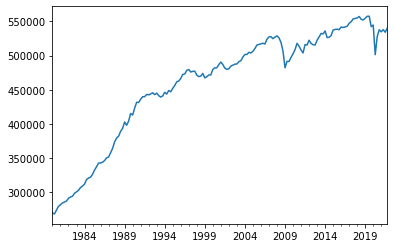

In [8]:
_ = df_gdp['gdp'].plot()

## 失業率

* 景気動向指数（速報、改訂値）（月次） 結果 個別系列の数値 遅行系列
    * ファイル名：0511ci3.xlsx
    * [ファイルのリンク](https://www.esri.cao.go.jp/jp/stat/di/di.html)

In [9]:
df_u = pd.read_excel('0511ci3.xlsx').iloc[64:568,[1,2,8]]
df_u.head()
# df_u.tail()

,Unnamed: 1,Unnamed: 2,Lg6
64,1980,1,1.95
65,1980,2,1.87
66,1980,3,1.94
67,1980,4,1.98
68,1980,5,1.95


列ラベルを変更

In [10]:
df_u.columns =['year','month','unemployment_rate']
df_u.head()

,year,month,unemployment_rate
64,1980,1,1.95
65,1980,2,1.87
66,1980,3,1.94
67,1980,4,1.98
68,1980,5,1.95


* インデックの変更
* 列`year`と`month`を削除

In [11]:
idx_u = pd.Series(pd.date_range(start, freq='M', periods=len(df_u)))
df_u = df_u.set_index(idx_u).drop(['year','month'],axis=1)
df_u.columns

Index(['unemployment_rate'], dtype='object')

* `float`に変換

In [12]:
df_u['unemployment_rate'] = df_u['unemployment_rate'].astype(float)

* 四半期の平均を計算
* 四半期最後の月に結果を挿入

In [13]:
df_u['unemployment_rate'] = df_u['unemployment_rate'].resample('Q',label='right').mean()

* 他の月を削除

In [14]:
df_u = df_u.dropna()

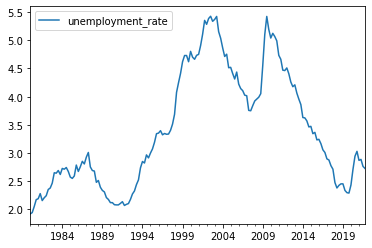

In [15]:
_ = df_u.plot()

## データの結合

* `df_gdp`と`df_u`の結合

In [16]:
df = pd.merge(left=df_gdp, right=df_u,
              left_index=True, right_index=True, how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1980-03-31 to 2021-12-31
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gdp                168 non-null    float64
 1   unemployment_rate  168 non-null    float64
dtypes: float64(2)
memory usage: 8.0 KB


## 変数の乖離

In [17]:
df['gdp_kairi'] = 100 * ( df['gdp'] / py4macro.trend(df['gdp']) - 1 )
df['u_kairi'] = df['unemployment_rate'] - py4macro.trend(df['unemployment_rate'])
df.head()

,gdp,unemployment_rate,gdp_kairi,u_kairi
1980-03-31,269747.5,1.920000,0.752303,-0.087693
1980-06-30,268521.8,1.943333,-0.736446,-0.109084
1980-09-30,274183.1,2.050000,0.324628,-0.047087
1980-12-31,279601.8,2.173333,1.275978,0.031755
1981-03-31,281995.7,2.190000,1.122977,0.004260


## ファイルの保存

* `gdp_growth`と`u_deviation`以外の列を削除

In [18]:
df = df[['gdp_kairi','u_kairi']]
df.head()

,gdp_kairi,u_kairi
1980-03-31,0.752303,-0.087693
1980-06-30,-0.736446,-0.109084
1980-09-30,0.324628,-0.047087
1980-12-31,1.275978,0.031755
1981-03-31,1.122977,0.004260


* このJupyter Notebookがあるフォルダーに`arukikata2022.csv`として保存する

In [19]:
df.reset_index().to_csv('arukikata2022.csv',index=False)

# 「Pythonによるマクロ経済分析」のコード

## データの読み込み

In [20]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols

url = 'https://bit.ly/3NkpZhQ'
df = pd.read_csv(url, index_col='index', parse_dates=True)

In [21]:
df.head()

,gdp_kairi,u_kairi
index,,
1980-03-31,0.752303,-0.087693
1980-06-30,-0.736446,-0.109084
1980-09-30,0.324628,-0.047087
1980-12-31,1.275978,0.031755
1981-03-31,1.122977,0.004260


In [22]:
df.shape

(168, 2)

## 図示と簡単な計算

In [23]:
df.mean()

gdp_kairi   -7.119104e-03
u_kairi      4.695293e-14
dtype: float64

In [24]:
df.std()

gdp_kairi    1.470419
u_kairi      0.230746
dtype: float64

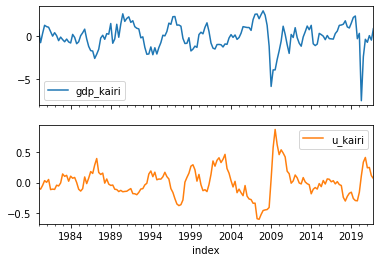

In [25]:
df.plot(subplots=True);

In [26]:
df.corr()

,gdp_kairi,u_kairi
gdp_kairi,1.000000,-0.630428
u_kairi,-0.630428,1.000000


In [27]:
df['gdp_kairi'].autocorr()

0.6907714988966259

In [28]:
df['u_kairi'].autocorr()

0.8763703453484804

## 最小二乗法による推定

In [29]:
formula = 'gdp_kairi ~ u_kairi'

In [30]:
model = ols(formula, data=df)

In [31]:
result = model.fit()

In [32]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              gdp_kairi   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     109.5
Date:                Fri, 10 Jun 2022   Prob (F-statistic):           5.34e-20
Time:                        13:40:26   Log-Likelihood:                -260.10
No. Observations:                 168   AIC:                             524.2
Df Residuals:                     166   BIC:                             530.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0071      0.088     -0.081      0.9

# 回帰直線のプロット

以下は原稿では使っていない。

In [39]:
import japanize_matplotlib  # 日本語を表示するために使う

In [40]:
df['予測値'] = result.fittedvalues

<AxesSubplot:xlabel='u_kairi', ylabel='gdp_kairi'>

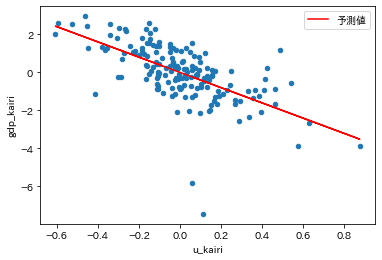

In [42]:
ax_ = df.plot(x='u_kairi', y='gdp_kairi', kind='scatter')
df.plot(x='u_kairi', y='予測値', color='red', ax=ax_)